In [1]:
crop = "winter_wheat"
scenario = 2017
res = "011"
watering = "rf"

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
from tqdm import tqdm
import datetime
import time
import sys 
import os 
from multiprocessing import Pool
import matplotlib.pyplot as plt

pd.set_option('mode.chained_assignment',None)

#local modules 

import home    
import dicts
import helperFunctions as hf
from p_calcGDD import calcGDD, calc_chill_fac_ldndc, calc_chill_units

In [3]:
mode = "test"
ggcmi_crop = dicts.crop_dict[crop]['GGCMI_crop_short']
print(f"Crop used: {crop}")
#%% read datasets
#scenic
scenic_da = xr.open_dataset(f"{home.climatepath}/scenic_EU{res}/scenic_EU{res}_ssp370_f{scenario}_daily.nc")
#crop calendar
cc_crop = xr.open_dataset(f"{home.hspath}/GGCMI_crop_calendars_EU{res}/{ggcmi_crop}_{watering}_ggcmi_crop_calendar_EU{res}.nc4")
 #check if data has the same extend
print(f"Using crop calendar: {ggcmi_crop}_{watering}_ggcmi_crop_calendar_EU{res}.nc4")
print(f"Climate Lats      : {scenic_da.lat.values[0]}, {scenic_da.lat.values[len(scenic_da.lat)-1]}, Length: {len(scenic_da.lat)} Res: {scenic_da.lat.values[0]-scenic_da.lat.values[1]}")
print(f"Crop Calendar Lats: {cc_crop.lat.values[0]}, {cc_crop.lat.values[len(cc_crop.lat)-1]}, Length: {len(cc_crop.lat)} Res: {cc_crop.lat.values[0]-cc_crop.lat.values[1]}")

print(f"Climate Lons      : {scenic_da.lon.values[0]}, {scenic_da.lon.values[len(scenic_da.lon)-1]}, Length: {len(scenic_da.lon)} Res: {scenic_da.lon.values[132]-scenic_da.lon.values[133]}")
print(f"Crop Calendar Lons: {cc_crop.lon.values[0]}, {cc_crop.lon.values[len(cc_crop.lon)-1]}, Length: {len(cc_crop.lon)} Res: {cc_crop.lon.values[132]-cc_crop.lon.values[133]}")

#%% 
timesteps = len(scenic_da.date)
print(pd.unique(scenic_da.date.dt.year), "(",round(timesteps/365,2), "Years)")

if mode == "test":
    if (res == "025"):
        lat_vals = [50.125, 50.375, 50.625, 50.875]
        lon_vals = [8.125, 8.375, 8.625, 8.875]
    if (res == "011"):
        lat_vals = [40.485 , 40.5961, 40.7072, 40.8183, 40.9294]
        lon_vals = [23.07  , 23.1813, 23.2926, 23.4039, 23.5152]
else: 
    lat_vals =  scenic_df.lat.values
    lon_vals = scenic_df.lon.values

latlon_list=[]

for lat in lat_vals:
    for lon in lon_vals:
        latlon_list.append((lat,lon))


cells  = len(lat_vals)*len(lon_vals)
print(cells, "Cells") 

scenic_da = scenic_da.sel(lat = slice(lat_vals[0],lat_vals[-1]),lon = slice(lon_vals[0],lon_vals[-1]))
scenic_df = scenic_da.to_dataframe().reset_index() 
year_vals = scenic_df.date.dt.year.unique()
#Get Plant parameters 
tbase = dicts.crop_dict[crop]['Tbase']
if dicts.crop_dict[crop]['vernalisation_flag'] == 1:
    chill_temp_max = dicts.crop_dict[crop]['chill_temp_max']
    req_chill_units = dicts.crop_dict[crop]['chill_units']
    scenic_df[f"achill"] = 0 

#create nan column for accumulated GDDs in dataframe 
scenic_df["aGDD"] = 0
scenic_df["aGDDvldndc"] = 0
scenic_df["aGDDvdssat"] = 0

Crop used: winter_wheat


/bg/home/martin-l/.local/lib/python3.9/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.0.3) or chardet (None)/charset_normalizer (3.0.1) doesn't match a supported version!
  warnings.warn(


Using crop calendar: wwh_rf_ggcmi_crop_calendar_EU011.nc4
Climate Lats      : 34.93, 67.8156, Length: 297 Res: -0.11110000000000042
Crop Calendar Lats: 34.93, 67.8156, Length: 297 Res: -0.11110000000000042
Climate Lons      : -10.32, 31.306199999999997, Length: 375 Res: -0.11129999999999995
Crop Calendar Lons: -10.32, 31.306199999999997, Length: 375 Res: -0.11129999999999995
[2017 2018 2019 2020 2021 2022] ( 5.67 Years)
25 Cells


In [4]:
def calc_chill_fac_dssat(veff,chill_units,required_chill_units):
    VF = (1-veff) + (veff * (chill_units/required_chill_units))
    return VF

In [5]:
def calc_chill_fac_ldndc(agdd,gdd_flowering,chill_units,required_chill_units):
    gdd_vernalization = 0.5 * gdd_flowering   
    fchill = 1
    chill_influence = 0
    if (agdd > gdd_vernalization):
        #print("required chill:", required_chill)
        chill_influence = min((agdd - gdd_vernalization ) / gdd_vernalization,1)
 
        fchill = 1- chill_influence +  ( chill_units / required_chill_units)
    if fchill > 1:
        fchill = 1
    if fchill < 0:
        fchill = 0
    if (agdd > gdd_flowering):
        fchill = 1
    return fchill

In [12]:
ilat = lat_vals[0]; ilon = lon_vals[0]

from tqdm.notebook import tqdm

##ilat = lat_vals[2]
#ilon = lon_vals[2]
print("lat,lon:",ilat,ilon)
# extract planting and harvest from crop calendar
planting_doy  = cc_crop.sel(lat=ilat,lon=ilon).planting_day.values
harvest_doy = cc_crop.sel(lat=ilat,lon=ilon).maturity_day.values
#print("planting,harvest doy:",planting_doy,harvest_doy)
#get index for cell 
spaceidx = ((scenic_df.lat == ilat) & (scenic_df.lon == ilon)).values
scenic_slice = scenic_df[spaceidx].set_index("date")
flowering_df = pd.DataFrame(index = year_vals)
flowering_df[["lat","lon"]] = ilat,ilon
# only process if there are values for that cell 
if np.any(scenic_slice) & all(~(np.isnan((harvest_doy,planting_doy)))): 
    #iterate over each year in one cell to define the growth period of the plant 
    for year in tqdm(year_vals,desc=f"{ilat},{ilon}",file=sys.stdout): #
        # convert the day of year to a date 
        planting_date = np.datetime64((datetime.datetime(year, 1, 1) +datetime.timedelta(planting_doy+0)).strftime("%Y-%m-%d"))
        # if the planting doy is larger than the harvest doy, this means the crop grows over the winter. 
        # the harvest date is therefore set to a year later
        if planting_doy < harvest_doy: 
            harvest_date = np.datetime64((datetime.datetime(year, 1, 1) +datetime.timedelta(harvest_doy+0)).strftime("%Y-%m-%d"))
        else: 
            harvest_date = np.datetime64((datetime.datetime(year+1, 1, 1) +datetime.timedelta(harvest_doy +0)).strftime("%Y-%m-%d"))
        # check if the date is still within the provided data 
        if  np.isin(np.datetime64(planting_date),scenic_slice.index): 
            # define the planting period
            plant_period = pd.date_range(planting_date,harvest_date)
            #iterate over the dates within the planting and sum up the GDDs 
            for date in plant_period:
                if  ((np.datetime64(date)  >= planting_date) & (np.datetime64(date) < harvest_date) & np.isin(np.datetime64(date),scenic_slice.index)):
                        #(np.isin(np.datetime64(date).astype('datetime64[Y]').astype("str"),year_vals.astype("str")))):
                        #print(scenic_date[scenic_date == date])
                        # get the cummulative temperature of the previous day
                        #tm1 = scenic_tcum[(scenic_date == (date-np.timedelta64(1,"D")))]
                        temp = scenic_slice.loc[date].tavg 
                        aGDD = scenic_slice.loc[date - np.timedelta64(1,"D"),"aGDD"]
                        aGDDvldndc = scenic_slice.loc[date - np.timedelta64(1,"D"),"aGDDvldndc"]
                        aGDDvdssat = scenic_slice.loc[date - np.timedelta64(1,"D"),"aGDDvdssat"]
                        if dicts.crop_dict[crop]['vernalisation_flag'] == 1:
                            scenic_slice.loc[date,"achill"] = calc_chill_units(scenic_slice.loc[date].tavg,chill_temp_max,scenic_slice.loc[date-np.timedelta64(1,"D")].achill)
                            #scenic_slice.loc[date,"fchill"] = calc_chill_fac_ldndc(scenic_slice.loc[date].aGDD,dicts.crop_dict[crop]["gdd_flowering"],scenic_slice.loc[date].achill,req_chill_units)
                            fchill_ldndc = calc_chill_fac_ldndc(aGDD,dicts.crop_dict[crop]["gdd_flowering"],scenic_slice.loc[date].achill,req_chill_units)
                            fchill_dssat = calc_chill_fac_dssat(0.6,scenic_slice.loc[date].achill,req_chill_units)
                        if (temp > tbase): 
                            if (temp > dicts.crop_dict[crop]['Tmax']):
                                temp = dicts.crop_dict[crop]['Tmax']
                            # add the current daily average temperature - base temperature 
                            teff = temp - tbase                 
                            #scenic_tcum[(date == scenic_slice.date.values)] = tm1 + teff
                            scenic_slice.loc[date,"aGDDvldndc"] = aGDDvldndc + teff * fchill_ldndc
                            scenic_slice.loc[date,"aGDDvdssat"] = aGDDvdssat + teff * (1- fchill_dssat)
                            scenic_slice.loc[date,"aGDD"] = aGDD + teff 
                        else: 
                            scenic_slice.loc[date,"aGDD"] = aGDD
                            scenic_slice.loc[date,"aGDDvldndc"] = aGDDvldndc
            # flowering things
            if  np.isin(np.datetime64(harvest_date),scenic_slice.index):

                #without vernalization
                maturity_gdd = scenic_slice.loc[plant_period[0]:plant_period[-1]].aGDD.max()
                if maturity_gdd < (dicts.crop_dict[crop]["gdd_maturity"]/2):
                    flowering_gdd,flowering_date = np.nan,np.nan
                else:
                    flowering_gdd = dicts.crop_dict[crop]["gdd_flowering"]/dicts.crop_dict[crop]["gdd_maturity"]*maturity_gdd
                    flowering_date = scenic_slice.loc[plant_period[0]:plant_period[-1]].loc[scenic_slice.aGDD > flowering_gdd].index[0]

                #with vernalization in ldndc 
                maturity_gddvldndc = scenic_slice.loc[plant_period[0]:plant_period[-1]].aGDDvldndc.max()
                if maturity_gddvldndc < (dicts.crop_dict[crop]["gdd_maturity"]/2):
                    flowering_gddvldndc,flowering_date_vldndc = np.nan,np.nan
                else:
                    flowering_gddvldndc = dicts.crop_dict[crop]["gdd_flowering"]/dicts.crop_dict[crop]["gdd_maturity"]*maturity_gddvldndc
                    flowering_date_vldndc = scenic_slice.loc[plant_period[0]:plant_period[-1]].loc[scenic_slice.aGDDvldndc > flowering_gddvldndc].index[0]
                
                #with vernalization in dssat
                maturity_gddvdssat = scenic_slice.loc[plant_period[0]:plant_period[-1]].aGDDvdssat.max()
                if maturity_gddvdssat < (dicts.crop_dict[crop]["gdd_maturity"]/2):
                    flowering_gddvdssat,flowering_date_vdssat = np.nan,np.nan
                else:
                    flowering_gddvdssat = dicts.crop_dict[crop]["gdd_flowering"]/dicts.crop_dict[crop]["gdd_maturity"]*maturity_gddvdssat
                    flowering_date_vdssat = scenic_slice.loc[plant_period[0]:plant_period[-1]].loc[scenic_slice.aGDDvdssat > flowering_gddvdssat].index[0]

                #write to df 
                flowering_df.loc[year+1,["flowering_gdd","flowering_date","flowering_gddvldndc","flowering_date_vldndc","flowering_gddvdssat","flowering_date_vdssat"]] = [flowering_gdd,flowering_date,flowering_gddvldndc,flowering_date_vldndc,flowering_gddvdssat,flowering_date_vdssat]


lat,lon: 40.485 23.07


40.485,23.07:   0%|          | 0/6 [00:00<?, ?it/s]

In [8]:
def calc_chill_fac(agdd,gdd_flowering,chill_units,required_chill_units):
    gdd_vernalization = 0.5 * gdd_flowering 
    #print("Vernalization at",gdd_vernalization,"GDD")
    chill_influence1,chill_influence2,chill_influence3,chill_influence4 = 0,0,0,0
    fchill1,fchill2,fchill3,fchill4 = 1,1,1,1
    chill_aquired=0
    
    if (agdd > gdd_vernalization):
        #print("required chill:", required_chill)
        chill_influence1 = (agdd - gdd_vernalization ) / gdd_vernalization
        chill_influence2 = ((agdd - gdd_vernalization ) / gdd_vernalization)**(1/2)
        chill_influence3 = ((agdd - gdd_vernalization ) / gdd_vernalization)*(2)
        chill_aquired = chill_units/required_chill_units
    if agdd > gdd_flowering:
        chill_influence1 = 0 
    if (required_chill_units - chill_units) < 35:
        #print(required_chill_units - chill_units)
        fchill1 =  1 - chill_aquired
        fchill2 =  1 - (chill_influence1 + chill_aquired)
        fchill3 =  1 - (chill_influence2 + chill_aquired)
        fchill4 =  1 - chill_influence1 + chill_aquired
        #fchill4 =  1 - chill_influence3 + chill_aquired
        #fchill4 =  1 - (chill_aquired + chill_influence1)
        #if fchill > 1:
            
        #print("Chilling Factor:",fchill)
    #    fchill = 1
    #if fchill < 0:
    #    fchill = 0
    #else: 
    #    fchill = 1
    if (agdd > gdd_flowering):
        fchill1 = 1
    return fchill1,chill_influence1,fchill2,fchill3,fchill4,chill_aquired,chill_influence2,chill_influence3

In [13]:
for date in scenic_slice.index:
    scenic_slice.loc[date,["fchill_dssat"]] = calc_chill_fac_dssat(0.6,scenic_slice.loc[date].achill,req_chill_units)
    scenic_slice.loc[date,["fchill_ldndc","chill_influence_ldndc"]] = calc_chill_fac_ldndc(scenic_slice.loc[date].aGDDvldndc,dicts.crop_dict[crop]["gdd_flowering"],scenic_slice.loc[date].achill,req_chill_units)
    #scenic_slice.loc[date,["fchill1","chill_influence1","fchill2","fchill3","fchill4","chill_aquired","chill_influence2","chill_influence3"]] = calc_chill_fac(scenic_slice.loc[date].aGDD,dicts.crop_dict[crop]["gdd_flowering"],scenic_slice.loc[date].achill,req_chill_units)

In [10]:
scenic_snip = scenic_slice["2017-09-25":"2018-08-24"]
scenic_snip = scenic_slice["2019-09-25":"2020-08-25"]
chill_reached = scenic_snip[scenic_snip.achill >= 35]

<Axes: xlabel='date'>

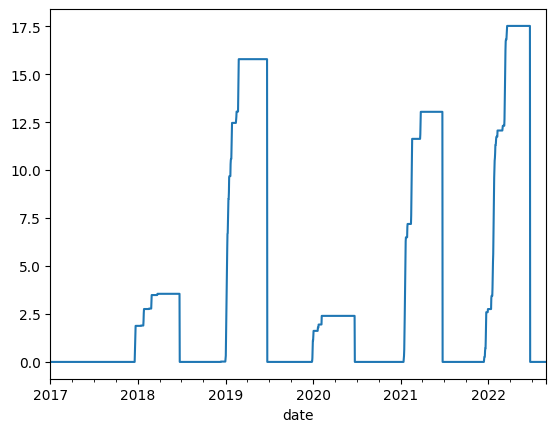

In [16]:
scenic_slice.achill.plot()

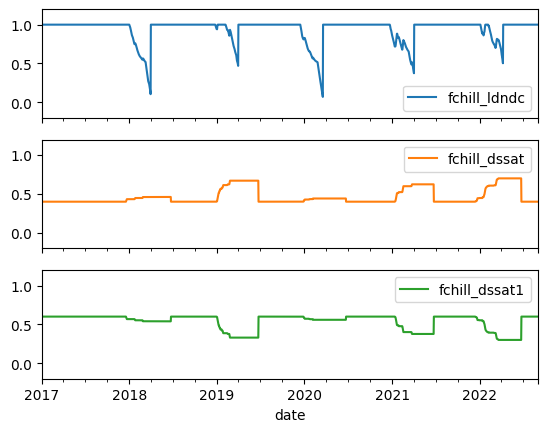

In [14]:

scenic_slice["fchill_dssat1"] = 1 - scenic_slice["fchill_dssat"]
scenic_slice[["fchill_ldndc","fchill_dssat","fchill_dssat1"]].plot(subplots=True,ylim=[-0.2,1.2]);
#plt.axvline(x = chill_reached);

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

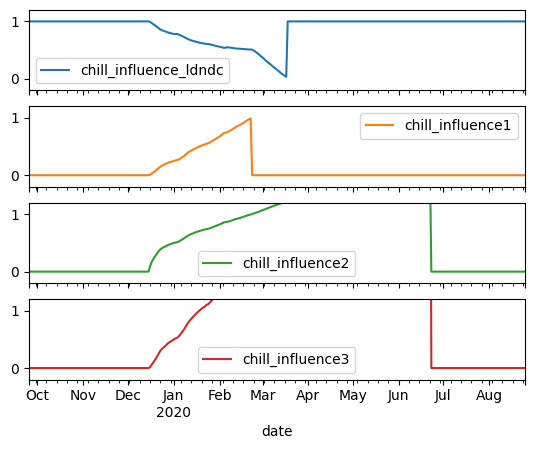

In [21]:
scenic_snip[["chill_influence_ldndc","chill_influence1","chill_influence2","chill_influence3"]].plot(subplots=True,ylim=[-0.2,1.2])


<Axes: xlabel='date'>

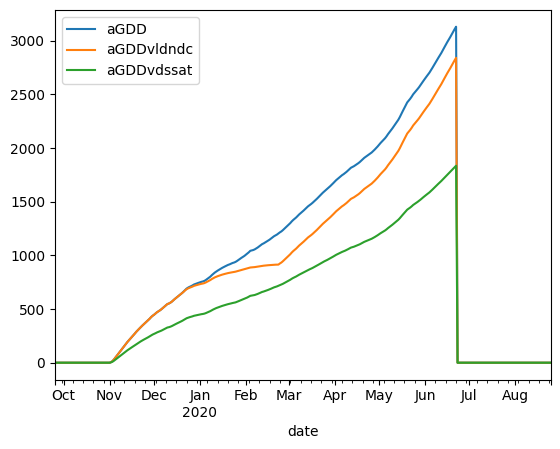

In [39]:
scenic_snip[["aGDD","aGDDvldndc","aGDDvdssat"]].plot()

<Axes: xlabel='date'>

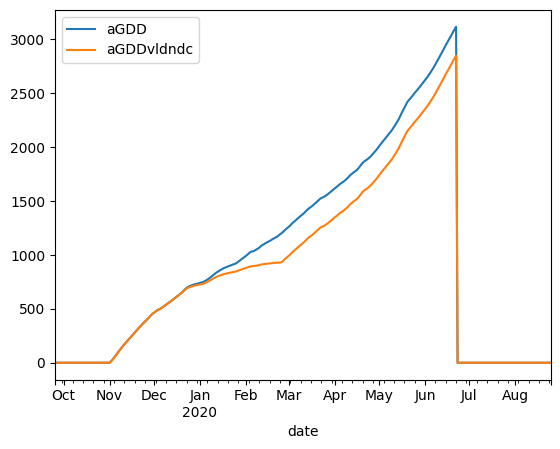

In [11]:
scenic_snip[["aGDD","aGDDvldndc"]].plot()

In [37]:
#scenic_slice["relGDD"] = scenic_slice["aGDD"]/scenic_slice["aGDD"].max()
#scenic_slice["relchill"] = scenic_slice["achill"]/scenic_slice["achill"].max()

scenic_snip[["aGDD","achill","chill_aquired"]].plot(subplots=True)
plt.axvline(x = chill_reached);

KeyError: "['chill_aquired'] not in index"

In [38]:
scenic_slicex = scenic_slice.reset_index().set_index(["date","lat","lon"])
scenic_dax = xr.Dataset()
scenic_dax = scenic_dax.from_dataframe(scenic_slicex)
 